# Amazon Fashion Items Ratings

This project is dedicated to create Recommender model.

We will use Amazon Fashion Review dataset from http://deepyeti.ucsd.edu/jianmo/amazon/index.html.

This dataset includes 883636 reviews. Each row corresponds to a customer review.

We will use these variables four our modelling:

* reviewerID - reviewer ID;

* asin - item ID;

* overal - rating. Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

For the sake of time, we will train a model using a part of reviews.

## Table of Contents

>[Amazon Fashion Items Ratings](#scrollTo=9LCH-OVcCszZ)

>>[Table of Contents](#scrollTo=nHdXFH4e1-KO)

>>[Imports & Data Download](#scrollTo=L9OgTj9DUaRN)

>>[Data Exploration](#scrollTo=Gid45OwSzO7M)

>>[Data Preprocessing](#scrollTo=sswugud68LtW)

>>>[Data Preprocessing - Small Dataset](#scrollTo=JzE_Vf9QDjoM)

>>>[Final Preprocessing of Full Dataset](#scrollTo=_kDG9PjxEQbt)

>>[Concatenated Model](#scrollTo=EbHd2BhlipvG)

>>[Dot Product Model](#scrollTo=uyWmvJ70ipvd)

>>[Combined Model](#scrollTo=_F1NaCHzipvn)

>>[Mean Model](#scrollTo=X7xKEqcvipvt)

>>[Combined Model (refactored)](#scrollTo=L1W5D41YCLOc)

>>[Hyperparameter tuning - Combined Model](#scrollTo=RAUNdhhCCLOm)

>>[Hyperparameter tuning - Dot Model](#scrollTo=L1fdnjV9CLO5)

>>[Hyperparameter tuning - Combined Model - using small dataset](#scrollTo=WI8ItGDki-yE)

>>["Hypered" Combined Model using best HP's found with small dataset](#scrollTo=UjhYY83z7_59)

>>["Hypered" Combined Model using best HP's found with full dataset](#scrollTo=MNUya4cnbyqu)

>>["Hypered" Dot Model using best HP's](#scrollTo=rkKeQHePtH7f)

>>[Model Evaluation & Summary](#scrollTo=R8XUza6fipvz)



## Imports & Data Download

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
!pip install -q -U toai
!pip install -q tensorflow-gpu==2.0.0
!pip install -q -U --no-deps tensorflow-addons~=0.6
!pip install -q -U keras-tuner

In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from toai.data.utils import split_df
import kerastuner as kt

In [0]:
tf.get_logger().setLevel("ERROR")

In [0]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.3.8
2.1.0-rc2


In [0]:
%matplotlib inline
plt.style.use('seaborn')

In [0]:
DATA_DIR = Path('./gdrive/My Drive/Projects/14_Recommenders/data/fashion')

In [0]:
TEMP_DIR = Path('./gdrive/My Drive/Projects/14_Recommenders/temp/fashion')

In [0]:
raw_df = pd.read_json(DATA_DIR/'AMAZON_FASHION.json',lines=True)

## Data Exploration

In [0]:
raw_df.shape

(883636, 12)

In [0]:
raw_df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [0]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
overall           883636 non-null int64
verified          883636 non-null bool
reviewTime        883636 non-null object
reviewerID        883636 non-null object
asin              883636 non-null object
reviewerName      883544 non-null object
reviewText        882403 non-null object
summary           883103 non-null object
unixReviewTime    883636 non-null int64
vote              79900 non-null float64
style             304569 non-null object
image             28807 non-null object
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [0]:
raw_df[['overall', 'verified', 'reviewTime', 'reviewerID', 'asin','unixReviewTime', 
       'style']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
overall,883636,NaN,NaN,NaN,3.90694,1.41828,1,3,5,5,5
verified,883636,2,True,828699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewTime,883636,4608,"01 15, 2016",3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewerID,883636,749233,A3G5KDMFNRUXHB,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asin,883636,186189,B000V0IBDM,4384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unixReviewTime,883636,NaN,NaN,NaN,1.45675e+09,4.43069e+07,1.03697e+09,1.43424e+09,1.46223e+09,1.48427e+09,1.53835e+09
style,304569,34309,{'Color:': ' Black'},8670,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Rating Distribution')

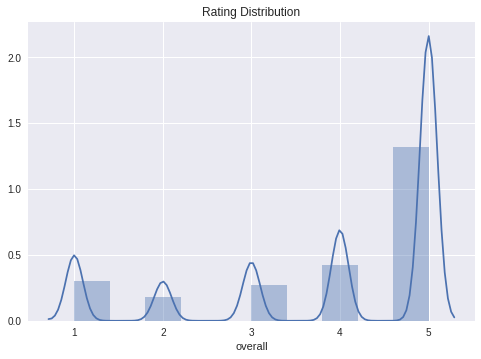

In [0]:
sns.distplot(raw_df['overall'], bins=10).set_title('Rating Distribution')

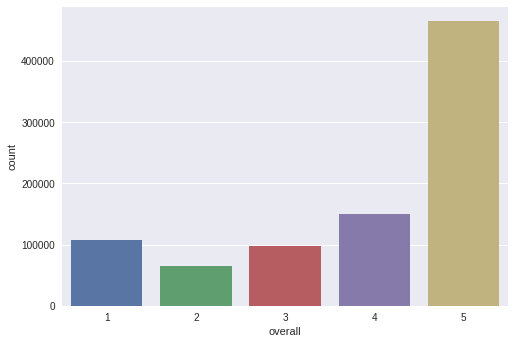

In [0]:
sns.countplot(raw_df['overall'])

In [0]:
raw_df[['review_day','review_year']] = raw_df.reviewTime.str.split(",", expand=True)

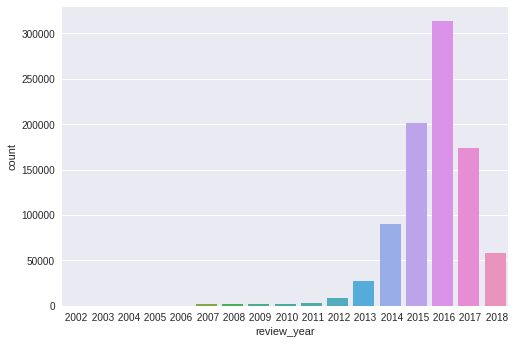

In [0]:
# Ratings distribution by year
sns.countplot(raw_df['review_year'])

In [0]:
raw_df.groupby('reviewerID')['asin'].count()

reviewerID
A0007604Q2582KFW7N4B    1
A0010606488RW7ZH6EP7    1
A001152055E9KVRHH96L    1
A00181966XZUX7KEGYLH    1
A00205926S885DTOYMX6    1
                       ..
AZZYFFDBSSBJC           1
AZZYVTX23JWKM           1
AZZYVURSF9KK6           1
AZZZMCJO078D2           1
AZZZU2YUCMUUW           1
Name: asin, Length: 749233, dtype: int64

In [0]:
# Number of reviews given by each reviewer (sorted in descending order)
raw_df.groupby('reviewerID')['asin'].count().reset_index(name='number_of_reviews').sort_values(by=['number_of_reviews'], ascending=False)

,reviewerID,number_of_reviews
484747,A3G5KDMFNRUXHB,40
502369,A3JBQHQZEZPQK4,36
152804,A1RRX286ZRI830,32
336862,A2PBHVTPTIIGKR,31
289496,A2GP4EJIAA2OE0,29
...,...,...
266200,A2CG7C9J02H5K4,1
266201,A2CG7LEC17PC4Q,1
266202,A2CG815JS3THFP,1
266203,A2CG87NHP8EONJ,1


In [0]:
# Number of reviews given for each item (sorted in descending order)
raw_df.groupby('asin')['reviewerID'].count().reset_index(name='number_of_reviews').sort_values(by=['number_of_reviews'], ascending=False)

,asin,number_of_reviews
3298,B000V0IBDM,4384
2453,B000KPIHQ4,4375
37176,B00I0VHS10,3889
71375,B00RLSCLJM,3638
2940,B000PHANNM,2572
...,...,...
81156,B00UW87NIM,1
81155,B00UW86OAU,1
81154,B00UW6XCT8,1
81153,B00UW6RIE8,1


In [0]:
table_itemID = pd.pivot_table(raw_df, values='reviewerID', index=['asin'], columns=['overall'], aggfunc='count', fill_value=0, margins=True)

In [0]:
# Number of each rating value given for each item (sorted in descending order)
table_itemID.sort_values(by=['All'], ascending=False)

overall,1,2,3,4,5,All
asin,,,,,,
All,107080,64718,97031,149331,465476,883636
B000V0IBDM,177,115,207,656,3229,4384
B000KPIHQ4,175,113,207,656,3224,4375
B00I0VHS10,159,163,263,512,2792,3889
B00RLSCLJM,45,24,69,243,3257,3638
...,...,...,...,...,...,...
B00UW87NIM,0,0,0,0,1,1
B00UW86OAU,1,0,0,0,0,1
B00UW6XCT8,1,0,0,0,0,1


In [0]:
table_reviewerID = pd.pivot_table(raw_df, values='asin', index=['reviewerID'], columns=['overall'], aggfunc='count', fill_value=0, margins=True)

In [0]:
# Number of each rating value given by each reviewer (sorted in descending order)
table_reviewerID.sort_values(by=['All'], ascending=False)

overall,1,2,3,4,5,All
reviewerID,,,,,,
All,107080,64718,97031,149331,465476,883636
A3G5KDMFNRUXHB,4,6,12,7,11,40
A3JBQHQZEZPQK4,0,0,1,2,33,36
A1RRX286ZRI830,1,0,2,3,26,32
A2PBHVTPTIIGKR,1,3,5,7,15,31
...,...,...,...,...,...,...
A2CG7LEC17PC4Q,0,0,0,0,1,1
A2CG815JS3THFP,0,0,1,0,0,1
A2CG87NHP8EONJ,0,0,0,0,1,1


## Data Preprocessing

In [0]:
# Selecting data for modeling
df = raw_df[raw_df['reviewTime'].str.contains('2017')]

In [0]:
df.shape

(174072, 12)

In [0]:
# Encoding ID's 
reviewerid_label_encoder = LabelEncoder()

In [0]:
reviewerid_label_encoder.fit(df['reviewerID'])

LabelEncoder()

In [0]:
joblib.dump(reviewerid_label_encoder, TEMP_DIR / "reviewerid_label_encoder.pickle")

In [0]:
df['reviewerID_encoded'] = reviewerid_label_encoder.transform(df['reviewerID'])

In [0]:
itemid_label_encoder = LabelEncoder()

In [0]:
itemid_label_encoder.fit(df['asin'])

LabelEncoder()

In [0]:
joblib.dump(itemid_label_encoder, TEMP_DIR / "itemid_label_encoder.pickle")

['gdrive/My Drive/Projects/14_Recommenders/temp/fashion/itemid_label_encoder.pickle']

In [0]:
df['asin_encoded'] = itemid_label_encoder.transform(df['asin'])

In [0]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,reviewerID_encoded,asin_encoded
15,3,True,"10 31, 2017",A1L1U968VNYVA4,B00007GDFV,J.G.,Love it but it tore up shortly after I got it....,Love it but it tore up shortly after I got ...,1509408000,NaN,{'Color:': ' Black'},NaN,24120,3
16,5,True,"10 24, 2017",A1NSKPSR0XZ0C9,B00007GDFV,Jules,I love it it is just what I was looking for th...,Perfect just what I was looking for!,1508803200,NaN,{'Color:': ' Black'},NaN,27252,3
17,5,False,"10 13, 2017",A3O5SXH5O8DWRP,B00007GDFV,Debra Humphreys,"Quality product, I am very happy with my purch...",I am very happy with my purchase,1507852800,NaN,{'Color:': ' Black'},NaN,111267,3


In [0]:
df.to_csv(TEMP_DIR/'AMAZON_FASHION_2017_mod.csv', index=False)

In [0]:
df = pd.read_csv(TEMP_DIR/'AMAZON_FASHION_2017_mod.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174072 entries, 0 to 174071
Data columns (total 14 columns):
overall               174072 non-null int64
verified              174072 non-null bool
reviewTime            174072 non-null object
reviewerID            174072 non-null object
asin                  174072 non-null object
reviewerName          174046 non-null object
reviewText            173773 non-null object
summary               173917 non-null object
unixReviewTime        174072 non-null int64
vote                  8724 non-null float64
style                 79490 non-null object
image                 6670 non-null object
reviewerID_encoded    174072 non-null int64
asin_encoded          174072 non-null int64
dtypes: bool(1), float64(1), int64(4), object(8)
memory usage: 17.4+ MB


In [0]:
train_df, val_df, test_df = split_df(df, 0.2)

In [0]:
target_col = "overall"

In [0]:
train_df[target_col].value_counts()

5    77096
4    21864
1    16112
3    14480
2     9705
Name: overall, dtype: int64

In [0]:
[x.shape for x in (train_df, val_df, test_df)]

[(139257, 14), (17407, 14), (17408, 14)]

In [0]:
train_df[target_col].values[:10]

array([4, 2, 3, 4, 3, 4, 4, 5, 1, 5])

### Data Preprocessing - Small Dataset

We will prepeare small dateset for a version of HP tuning using higher number of trials.

In [0]:
train_df_small, _ = train_test_split(train_df, train_size=0.1, random_state=42)
train_df_small, val_df_small = train_test_split(train_df_small, test_size=0.2, random_state=42)

In [0]:
[x.shape for x in (train_df_small, val_df_small)]

[(11140, 14), (2785, 14)]

In [0]:
train_df_small[target_col].value_counts()

5    6129
4    1771
1    1287
3    1179
2     774
Name: overall, dtype: int64

In [0]:
val_df_small[target_col].value_counts()

5    1606
4     428
1     304
3     271
2     176
Name: overall, dtype: int64

In [0]:
train_df_small[target_col].values[:10]

array([2, 5, 3, 3, 5, 2, 3, 5, 5, 2])

In [0]:
scaler_small = MinMaxScaler(feature_range=(0, 1))

In [0]:
scaler_small.fit(train_df_small[[target_col]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
joblib.dump(scaler_small, TEMP_DIR / "scaler_small.pickle")

['gdrive/My Drive/Projects/14_Recommenders/temp/fashion/scaler_small.pickle']

In [0]:
scaler_small = joblib.load(TEMP_DIR / "scaler_small.pickle")

In [0]:
train_df_small[target_col] = scaler_small.transform(train_df_small[[target_col]])

In [0]:
val_df_small[target_col] = scaler_small.transform(val_df_small[[target_col]])

In [0]:
scaler_small.inverse_transform(train_df_small[[target_col]][:10]).flatten()

array([2., 5., 3., 3., 5., 2., 3., 5., 5., 2.])

In [0]:
train_df_small.to_csv(TEMP_DIR/'train_df_small.csv', index=False)

In [0]:
train_df_small = pd.read_csv(TEMP_DIR/'train_df_small.csv')

In [0]:
val_df_small.to_csv(TEMP_DIR/'val_df_small.csv', index=False)

In [0]:
val_df_small = pd.read_csv(TEMP_DIR/'val_df_small.csv')

In [0]:
train_df_small[target_col].value_counts()

1.00    6129
0.75    1771
0.00    1287
0.50    1179
0.25     774
Name: overall, dtype: int64

In [0]:
val_df_small[target_col].value_counts()

1.00    1606
0.75     428
0.00     304
0.50     271
0.25     176
Name: overall, dtype: int64

In [0]:
user_id = 'reviewerID_encoded'

In [0]:
item_id = 'asin_encoded'

In [0]:
BATCH_SIZE = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
train_df_small[user_id].max(), val_df_small[user_id].max()

(157394, 157164)

In [0]:
train_df_small[item_id].max(), val_df_small[item_id].max()

(54440, 54383)

In [0]:
n_users = 158000

In [0]:
n_items = 55000

In [0]:
n_users, n_items

(158000, 55000)

In [0]:
train_dataset_small = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df_small[user_id].values, train_df_small[item_id].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df_small[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df_small))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
val_dataset_small = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (val_df_small[user_id].values, val_df_small[item_id].values)
            ),
            tf.data.Dataset.from_tensor_slices(val_df_small[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
train_data_steps_small = len(train_df_small) // BATCH_SIZE

### Final Preprocessing of Full Dataset

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
scaler.fit(train_df[[target_col]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
joblib.dump(scaler, TEMP_DIR / "scaler.pickle")

['gdrive/My Drive/Projects/14_Recommenders/temp/fashion/scaler.pickle']

In [0]:
scaler = joblib.load(TEMP_DIR / "scaler.pickle")

In [0]:
train_df[target_col] = scaler.transform(train_df[[target_col]])

In [0]:
val_df[target_col] = scaler.transform(val_df[[target_col]])

In [0]:
scaler.inverse_transform(train_df[[target_col]][:10]).flatten()

array([4., 2., 3., 4., 3., 4., 4., 5., 1., 5.])

In [0]:
train_df.to_csv(TEMP_DIR/'train_df.csv', index=False)

In [0]:
train_df = pd.read_csv(TEMP_DIR/'train_df.csv')

In [0]:
val_df.to_csv(TEMP_DIR/'val_df.csv', index=False)

In [0]:
val_df = pd.read_csv(TEMP_DIR/'val_df.csv')

In [0]:
test_df.to_csv(TEMP_DIR/'test_df.csv', index=False)

In [0]:
test_df = pd.read_csv(TEMP_DIR/'test_df.csv')

In [0]:
[x.shape for x in (train_df, val_df, test_df)]

[(139257, 14), (17407, 14), (17408, 14)]

In [0]:
train_df[target_col].value_counts()

1.00    77096
0.75    21864
0.00    16112
0.50    14480
0.25     9705
Name: overall, dtype: int64

In [0]:
val_df[target_col].value_counts()

1.00    9693
0.75    2785
0.00    1946
0.50    1777
0.25    1206
Name: overall, dtype: int64

In [0]:
test_df[target_col].value_counts()

5    9831
4    2671
1    1930
3    1824
2    1152
Name: overall, dtype: int64

In [0]:
user_id = 'reviewerID_encoded'

In [0]:
item_id = 'asin_encoded'

In [0]:
BATCH_SIZE = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
train_df[user_id].max(), val_df[user_id].max()

(157398, 157374)

In [0]:
train_df[item_id].max(), val_df[item_id].max()

(54440, 54440)

In [0]:
n_users = 158000

In [0]:
n_items = 55000

In [0]:
n_users, n_items

(158000, 55000)

In [0]:
train_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df[user_id].values, train_df[item_id].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
val_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (val_df[user_id].values, val_df[item_id].values)
            ),
            tf.data.Dataset.from_tensor_slices(val_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
train_data_steps = len(train_df) // BATCH_SIZE

## Concatenated Model

In [0]:
def make_concatenated_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
concatenated_model = make_concatenated_model(
    n_users,
    n_items,
    128,
    layer_size=256,
    dropout_rate=0.2,
    regularization=(1e-8, 1e-4),
)

In [0]:
concatenated_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       20224000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1)         158000      input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
concatenated_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

make_concatenated_model_history = concatenated_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'concat_model_v1.h5'), save_best_only=True),       
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=1,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30
271/271 [==============================] - 41s 152ms/step - loss: 0.2095 - mean_absolute_error: 0.3378 - val_loss: 0.1682 - val_mean_absolute_error: 0.2756
Epoch 2/30
271/271 [==============================] - 40s 148ms/step - loss: 0.1534 - mean_absolute_error: 0.2615 - val_loss: 0.1603 - val_mean_absolute_error: 0.2659
Epoch 3/30
271/271 [==============================] - 41s 150ms/step - loss: 0.1186 - mean_absolute_error: 0.2101 - val_loss: 0.1585 - val_mean_absolute_error: 0.2666
Epoch 4/30
271/271 [==============================] - 39s 143ms/step - loss: 0.0854 - mean_absolute_error: 0.1568 - val_loss: 0.1600 - val_mean_absolute_error: 0.2671
Epoch 5/30
271/271 [==============================] - 40s 148ms/step - loss: 0.0630 - mean_absolute_error: 0.1197 - val_loss: 0.1576 - val_mean_absolute_error: 0.2648
Epoch 6/30
271/271 [==============================] - 40s 146ms/step - loss: 0.0508 - mean_absolute_error: 0.1007 - val_lo

In [0]:
concat_model.evaluate(val_dataset)

34/34 [==============================] - 2s 49ms/step - loss: 0.1176 - mean_absolute_error: 0.2713


[0.11763294391772326, 0.27131236]

In [0]:
print('concat_model val RMSE:', evaluate_predictions(concat_model, val_dataset, scaler))

concat_model val RMSE: 1.3695277123233034


In [0]:
def evaluate_predictions(model, dataset, scaler):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Dot Product Model

In [0]:
def make_dot_model(
    user_dim, item_dim, embedding_dim,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    
    return model

In [0]:
dot_model = make_dot_model(n_users, n_items, 128)

In [0]:
dot_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 128)       20224000    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 128)       7040000     input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

dot_model_history = dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
               keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'dot_model_v1.h5'), save_best_only=True),
               keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
               keras.callbacks.EarlyStopping(
                   patience=PATIENCE * 2, restore_best_weights=True
                   ),
               keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/dot_model_v1/'))
               ],
    verbose=2,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30
271/271 - 69s - loss: 0.1740 - mean_absolute_error: 0.3836 - val_loss: 0.1772 - val_mean_absolute_error: 0.3877
Epoch 2/30
271/271 - 69s - loss: 0.1683 - mean_absolute_error: 0.3770 - val_loss: 0.1746 - val_mean_absolute_error: 0.3849
Epoch 3/30
271/271 - 68s - loss: 0.1599 - mean_absolute_error: 0.3669 - val_loss: 0.1717 - val_mean_absolute_error: 0.3813
Epoch 4/30
271/271 - 68s - loss: 0.1491 - mean_absolute_error: 0.3527 - val_loss: 0.1686 - val_mean_absolute_error: 0.3773
Epoch 5/30
271/271 - 68s - loss: 0.1370 - mean_absolute_error: 0.3360 - val_loss: 0.1658 - val_mean_absolute_error: 0.3731
Epoch 6/30
271/271 - 69s - loss: 0.1241 - mean_absolute_error: 0.3165 - val_loss: 0.1635 - val_mean_absolute_error: 0.3696
Epoch 7/30
271/271 - 68s - loss: 0.1111 - mean_absolute_error: 0.2964 - val_loss: 0.1617 - val_mean_absolute_error: 0.3667
Epoch 8/30
271/271 - 68s - loss: 0.0978 - mean_absolute_error: 0.2740 - val_loss: 0.1602 - val_m

In [0]:
dot_model.evaluate(val_dataset)

34/34 [==============================] - 0s 4ms/step - loss: 0.1519 - mean_absolute_error: 0.3492


[0.151865492848789, 0.34920165]

In [0]:
print('dot_model val RMSE:', evaluate_predictions(dot_model, val_dataset, scaler))

dot_model val RMSE: 1.5587967356901944


## Combined Model

In [0]:
def make_combined_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)
    x1 = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
combined_model = make_combined_model(
    n_users,
    n_items,
    128,
    layer_size=256,
    dropout_rate=0.2,
    regularization=(1e-8, 1e-4),
)

In [0]:
combined_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

combined_model_history = combined_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'combined_model_v1.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
        keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/combined_model_v1/'))

    ],
    verbose=2,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30
271/271 - 71s - loss: 0.2071 - mean_absolute_error: 0.3392 - val_loss: 0.1648 - val_mean_absolute_error: 0.2790
Epoch 2/30
271/271 - 69s - loss: 0.1515 - mean_absolute_error: 0.2622 - val_loss: 0.1574 - val_mean_absolute_error: 0.2680
Epoch 3/30
271/271 - 64s - loss: 0.1141 - mean_absolute_error: 0.2057 - val_loss: 0.1584 - val_mean_absolute_error: 0.2679
Epoch 4/30
271/271 - 63s - loss: 0.0802 - mean_absolute_error: 0.1505 - val_loss: 0.1595 - val_mean_absolute_error: 0.2680
Epoch 5/30
271/271 - 64s - loss: 0.0598 - mean_absolute_error: 0.1160 - val_loss: 0.1567 - val_mean_absolute_error: 0.2665
Epoch 6/30
271/271 - 64s - loss: 0.0486 - mean_absolute_error: 0.0992 - val_loss: 0.1528 - val_mean_absolute_error: 0.2652
Epoch 7/30
271/271 - 64s - loss: 0.0411 - mean_absolute_error: 0.0898 - val_loss: 0.1478 - val_mean_absolute_error: 0.2643
Epoch 8/30
271/271 - 64s - loss: 0.0352 - mean_absolute_error: 0.0829 - val_loss: 0.1435 - val_m

In [0]:
combined_model.evaluate(val_dataset)

34/34 [==============================] - 0s 4ms/step - loss: 0.1188 - mean_absolute_error: 0.2733


[0.11877826732747696, 0.27332413]

In [0]:
print('combined_model Val RMSE:', evaluate_predictions(combined_model, val_dataset, scaler))

combined_model Val RMSE: 1.37652184694296


## Mean Model

In [0]:
class MeanModel(keras.Model):
    def __init__(self, mean):
        super().__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)

    def call(self, inputs):
        return tf.ones_like(inputs[0], dtype=tf.float32) * self.mean

In [0]:
mean_model = MeanModel(train_df[target_col].mean())

In [0]:
mean_model.compile(
    optimizer=keras.optimizers.Adam(3e-4), loss=keras.losses.mse,
)

In [0]:
mean_model.predict(val_dataset)

array([[0.7407904],
       [0.7407904],
       [0.7407904],
       ...,
       [0.7407904],
       [0.7407904],
       [0.7407904]], dtype=float32)

In [0]:
mean_model.evaluate(val_dataset)

34/34 [==============================] - 0s 3ms/step - loss: 0.1214


0.12138436471714693

In [0]:
print('Mean model val RMSE:', evaluate_predictions(mean_model, val_dataset, scaler))

Mean model val RMSE: 1.393610610927046


## Combined Model (refactored)

In [0]:
class EmbeddingLayer:
    def __init__(self, input_dim: int, embedding_dim: int):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim, self.embedding_dim, input_length=(1,),
        )(layer)
        return keras.layers.Flatten()(layer)

In [0]:
def make_refactored_combined_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)
    x1 = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
ref_comb_model = make_refactored_combined_model(
    n_users,
    n_items,
    128,
    layer_size=256,
    dropout_rate=0.2,
    regularization=(1e-8, 1e-4),
)

In [0]:
ref_comb_model.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

ref_comb_model_history = ref_comb_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'refactored_combined_model_v1.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
        keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/refactored_combined_model_v1/'))

    ],
    verbose=1,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30
271/271 [==============================] - 86s 319ms/step - loss: 0.1926 - mean_absolute_error: 0.3165 - val_loss: 0.1802 - val_mean_absolute_error: 0.2667
Epoch 2/30
271/271 [==============================] - 83s 306ms/step - loss: 0.1325 - mean_absolute_error: 0.2335 - val_loss: 0.1663 - val_mean_absolute_error: 0.2578
Epoch 3/30
271/271 [==============================] - 79s 292ms/step - loss: 0.0863 - mean_absolute_error: 0.1624 - val_loss: 0.1523 - val_mean_absolute_error: 0.2565
Epoch 4/30
271/271 [==============================] - 78s 288ms/step - loss: 0.0574 - mean_absolute_error: 0.1169 - val_loss: 0.1473 - val_mean_absolute_error: 0.2570
Epoch 5/30
271/271 [==============================] - 78s 287ms/step - loss: 0.0435 - mean_absolute_error: 0.0978 - val_loss: 0.1405 - val_mean_absolute_error: 0.2558
Epoch 6/30
271/271 [==============================] - 78s 287ms/step - loss: 0.0346 - mean_absolute_error: 0.0875 - val_lo

In [0]:
ref_comb_model.evaluate(val_dataset)

34/34 [==============================] - 1s 38ms/step - loss: 0.1154 - mean_absolute_error: 0.2661


[0.1153859774417737, 0.2661316]

In [0]:
print('refactored_combined_model Val RMSE:', evaluate_predictions(ref_comb_model, val_dataset, scaler))

refactored_combined_model Val RMSE: 1.3541075930273054


## Hyperparameter tuning - Combined Model

In [0]:
class EmbeddingLayer:
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        embeddings_regularization_l2: float = 0.0,
    ):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.embeddings_regularization_l2 = embeddings_regularization_l2

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim,
            self.embedding_dim,
            input_length=(1,),
            embeddings_regularizer=keras.regularizers.l2(
                self.embeddings_regularization_l2
            ),
        )(layer)
        return keras.layers.Flatten()(layer)

In [0]:
def make_hyper_combined_model(hp):
    embedding_dim = hp.Choice("embedding_dim", [16, 32, 64, 128, 256])
    user_dim = hp.Fixed("user_dim", 1)
    item_dim = hp.Fixed("item_dim", 1)
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(
        user_dim,
        embedding_dim,
        hp.Float(
            "user_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(
        item_dim,
        embedding_dim,
        hp.Float(
            "item_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(
        hp.Float("dropout_rate1", min_value=0.0, max_value=0.8, step=0.1)
    )(x1)
    x1 = keras.layers.Dense(
        hp.Choice("layer_size", [16, 32, 64, 128, 256]),
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=keras.regularizers.l2(
            hp.Float(
                "kernel_regularizer", min_value=1e-8, max_value=1e-2, sampling="log"
            )
        ),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(
        hp.Float("dropout_rate2", min_value=0.0, max_value=0.8, step=0.1)
    )(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(
        hp.Choice("final_activation", ["sigmoid", "linear"])
    )(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [3e-3, 1e-3, 5e-4, 3e-4, 1e-4])
        ),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mae],
    )
    return model

In [0]:
hp = kt.HyperParameters()
hp.Fixed("user_dim", n_users)
hp.Fixed("item_dim", n_items)

tuner = kt.tuners.RandomSearch(
    make_hyper_combined_model,
    objective="val_loss",
    max_trials=10,
    tune_new_entries=True,
    hyperparameters=hp,
    directory=TEMP_DIR,
    project_name="make_hyper_combined_model",
)

In [0]:
tuner.search_space_summary()

In [0]:
PATIENCE = 3
tuner.search(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=12,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Oracle triggered exit


In [0]:
[tuner.get_best_models(num_models=3)[i].evaluate(val_dataset) for i in range(3)]

34/34 [==============================] - 2s 67ms/step - loss: 0.1275 - mean_absolute_error: 0.2723


[[0.11459263764760073, 0.26993194],
 [0.1209978629999301, 0.28585884],
 [0.12745756392969804, 0.27226552]]

In [0]:
tuner.results_summary()

In [0]:
best_hps = tuner.get_best_hyperparameters()[0]

In [0]:
best_hps.values

{'dropout_rate1': 0.2,
 'dropout_rate2': 0.0,
 'embedding_dim': 128,
 'final_activation': 'linear',
 'item_dim': 55000,
 'item_embeddings_regularization_l2': 2.7893512209492955e-07,
 'kernel_regularizer': 4.130402344033765e-07,
 'layer_size': 32,
 'learning_rate': 0.003,
 'user_dim': 158000,
 'user_embeddings_regularization_l2': 5.0238227849975426e-08}

In [0]:
for model in tuner.get_best_models(num_models=3):
    print('Hyper_combined_model val RMSE:', evaluate_predictions(model, val_dataset, scaler))

Hyper_combined_model val RMSE: 1.3235514571450202
Hyper_combined_model val RMSE: 1.361399126890093
Hyper_combined_model val RMSE: 1.3683936925193176


## Hyperparameter tuning - Dot Model

In [0]:
def make_hyper_dot_model(hp):
    embedding_dim = hp.Choice("embedding_dim", [16, 32, 64, 128, 256])
    user_dim = hp.Fixed("user_dim", 1)
    item_dim = hp.Fixed("item_dim", 1)
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(
        user_dim,
        embedding_dim,
        hp.Float(
            "user_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(user_input)
    user_embedding = keras.layers.Dropout(
        hp.Float("user_embedding_dropout", min_value=0.0, max_value=0.8, step=0.1)
    )(user_embedding)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(
        item_dim,
        embedding_dim,
        hp.Float(
            "item_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(item_input)
    item_embedding = keras.layers.Dropout(
        hp.Float("item_embedding_dropout", min_value=0.0, max_value=0.8, step=0.1)
    )(item_embedding)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation("sigmoid")(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [3e-3, 1e-3, 5e-4, 3e-4, 1e-4])
        ),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mae],
    )
    return model

In [0]:
hp = kt.HyperParameters()
hp.Fixed("user_dim", n_users)
hp.Fixed("item_dim", n_items)

tuner = kt.tuners.RandomSearch(
    make_hyper_dot_model,
    objective="val_loss",
    max_trials=10,
    hyperparameters=hp,
    directory=TEMP_DIR,
    project_name="hyper_dot_model",
)

In [0]:
tuner.search_space_summary()

In [0]:
PATIENCE = 5

tuner.search(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
tuned_models = tuner.get_best_models(num_models=3)

In [0]:
[tuned_models[i].evaluate(val_dataset) for i in range(3)]

34/34 [==============================] - 0s 13ms/step - loss: 0.1268 - mean_absolute_error: 0.3105


[[0.12228458506219528, 0.2953445],
 [0.1257658528492731, 0.28867066],
 [0.12678459352430174, 0.31047717]]

In [0]:
tuner.results_summary()

In [0]:
best_hps = tuner.get_best_hyperparameters()[0]

In [0]:
best_hps.values

{'embedding_dim': 128,
 'item_dim': 55000,
 'item_embedding_dropout': 0.6000000000000001,
 'item_embeddings_regularization_l2': 0.008160881992421628,
 'learning_rate': 0.003,
 'user_dim': 158000,
 'user_embedding_dropout': 0.2,
 'user_embeddings_regularization_l2': 6.558657266967806e-07}

In [0]:
for model in tuner.get_best_models(num_models=3):
    print('Hyper_dot_model val RMSE:', evaluate_predictions(model, val_dataset, scaler))

Hyper_dot_model val RMSE: 1.398769780776253
Hyper_dot_model val RMSE: 1.3904498555811298
Hyper_dot_model val RMSE: 1.4242737747479395


## Hyperparameter tuning - Combined Model - using small dataset

We will do HP Combined model tuning using small dataset and increasing nuber of trials to 100.

In [0]:
hp = kt.HyperParameters()
hp.Fixed("user_dim", n_users)
hp.Fixed("item_dim", n_items)

tuner = kt.tuners.RandomSearch(
    make_hyper_combined_model,
    objective="val_loss",
    max_trials=100,
    tune_new_entries=True,
    hyperparameters=hp,
    directory=TEMP_DIR,
    project_name="make_hyper_combined_model_small_2",
)

In [0]:
tuner.search_space_summary()

In [0]:
PATIENCE = 4

tuner.search(
    train_dataset_small,
    steps_per_epoch=train_data_steps_small,
    validation_data=val_dataset_small,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
tuner.results_summary()

In [0]:
best_hps = tuner.get_best_hyperparameters()[0]

In [0]:
best_hps.values

{'dropout_rate1': 0.1,
 'dropout_rate2': 0.4,
 'embedding_dim': 16,
 'final_activation': 'sigmoid',
 'item_dim': 55000,
 'item_embeddings_regularization_l2': 7.064865007438106e-08,
 'kernel_regularizer': 1.8730282664510986e-08,
 'layer_size': 16,
 'learning_rate': 0.0005,
 'user_dim': 158000,
 'user_embeddings_regularization_l2': 8.006516336469135e-06}

In [0]:
[tuner.get_best_models(num_models=3)[i].evaluate(val_dataset_small) for i in range(3)]

6/6 [==============================] - 0s 29ms/step - loss: 0.1186 - mean_absolute_error: 0.2805


[[0.11728272835413615, 0.2813161],
 [0.11766773213942845, 0.27935183],
 [0.11857452740271886, 0.28049397]]

In [0]:
for model in tuner.get_best_models(num_models=3):
    print('Hyper_combined_model_small val RMSE:', evaluate_predictions(model, val_dataset_small, scaler_small))

Hyper_combined_model_small val RMSE: 1.371731128129157
Hyper_combined_model_small val RMSE: 1.3754832259060297
Hyper_combined_model_small val RMSE: 1.3747896999468738


## "Hypered" Combined Model using best HP's found with small dataset

We will use best HP's found from HP tuning, when we used small dataset.

In [0]:
dropout_rate1 = 0.1
dropout_rate2 =0.4
embedding_dim =16
final_activation ='sigmoid'
item_dim = 55000
item_embeddings_regularization_l2= 7.064865007438106e-08
kernel_regularizer= 1.8730282664510986e-08
layer_size =16
learning_rate =0.0005
user_dim =158000
user_embeddings_regularization_l2 = 8.006516336469135e-06

In [0]:
class EmbeddingLayer:
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        embeddings_regularization_l2: float = 0.0,
    ):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.embeddings_regularization_l2 = embeddings_regularization_l2

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim,
            self.embedding_dim,
            input_length=(1,),
            embeddings_regularizer=keras.regularizers.l2(
                self.embeddings_regularization_l2
            ),
        )(layer)
        return keras.layers.Flatten()(layer)

In [0]:
def make_final_combined_model():
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(
        user_dim,
        embedding_dim,
        user_embeddings_regularization_l2,
    )(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(
        item_dim,
        embedding_dim,
        item_embeddings_regularization_l2,
    )(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate1)(x1)
    x1 = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=keras.regularizers.l2(kernel_regularizer),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate2)(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(final_activation)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    return model

In [0]:
hypered_comb_model_s = make_final_combined_model()

In [0]:
hypered_comb_model_s.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

hypered_comb_model_s_history = hypered_comb_model_s.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'final_combined_model_v1.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
        keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/final_combined_model_v1/'))

    ],
    verbose=2,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


271/271 - 6s - loss: 0.1943 - mean_absolute_error: 0.3686 - val_loss: 0.1419 - val_mean_absolute_error: 0.3426
Epoch 2/30
271/271 - 3s - loss: 0.1182 - mean_absolute_error: 0.2801 - val_loss: 0.1203 - val_mean_absolute_error: 0.2915
Epoch 3/30
271/271 - 3s - loss: 0.0681 - mean_absolute_error: 0.1895 - val_loss: 0.1183 - val_mean_absolute_error: 0.2642
Epoch 4/30
271/271 - 3s - loss: 0.0404 - mean_absolute_error: 0.1337 - val_loss: 0.1199 - val_mean_absolute_error: 0.2563
Epoch 5/30
271/271 - 3s - loss: 0.0289 - mean_absolute_error: 0.1082 - val_loss: 0.1197 - val_mean_absolute_error: 0.2533
Epoch 6/30
271/271 - 3s - loss: 0.0231 - mean_absolute_error: 0.0944 - val_loss: 0.1192 - val_mean_absolute_error: 0.2524
Epoch 7/30
271/271 - 3s - loss: 0.0201 - mean_absolute_error: 0.0857 - val_loss: 0.1186 - val_mean_absolute_error: 0.2523
Epoch 8/30
271/271 - 4s - loss: 0.0176 - mean_absolute_error: 0.0789 - val_loss: 0.1177 - val_mean_absolute_error: 0.2520
Epoch 9/30
271/271 - 3s - loss: 0.0

In [0]:
hypered_comb_model_s.evaluate(val_dataset)

34/34 [==============================] - 0s 8ms/step - loss: 0.1162 - mean_absolute_error: 0.2527


[0.11618317444534863, 0.25273952]

In [0]:
print('hypered_comb_model_s Val RMSE:', evaluate_predictions(hypered_comb_model_s, val_dataset, scaler))

hypered_comb_model_s Val RMSE: 1.3429120127713974


## "Hypered" Combined Model using best HP's found with full dataset

We will use best HP's found from HP tuning, when we used full dataset.

In [0]:
 dropout_rate1 = 0.2
 dropout_rate2 = 0.0
 embedding_dim = 128
 final_activation = 'linear'
 item_dim = 55000
 item_embeddings_regularization_l2 = 2.7893512209492955e-07
 kernel_regularizer = 4.130402344033765e-07
 layer_size = 32
 learning_rate = 0.003
 user_dim = 158000
 user_embeddings_regularization_l2 = 5.0238227849975426e-08

In [0]:
hypered_comb_model = make_final_combined_model()

In [0]:
hypered_comb_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [0]:
PATIENCE = 5

hypered_comb_model_history = hypered_comb_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'final_combined_model_v2.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
        keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/final_combined_model_v2/'))

    ],
    verbose=2,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


271/271 - 21s - loss: 0.1987 - mean_absolute_error: 0.3338 - val_loss: 0.1233 - val_mean_absolute_error: 0.2824
Epoch 2/30
271/271 - 19s - loss: 0.0726 - mean_absolute_error: 0.2014 - val_loss: 0.1182 - val_mean_absolute_error: 0.2769
Epoch 3/30
271/271 - 19s - loss: 0.0450 - mean_absolute_error: 0.1481 - val_loss: 0.1162 - val_mean_absolute_error: 0.2644
Epoch 4/30
271/271 - 18s - loss: 0.0296 - mean_absolute_error: 0.1103 - val_loss: 0.1173 - val_mean_absolute_error: 0.2592
Epoch 5/30
271/271 - 19s - loss: 0.0216 - mean_absolute_error: 0.0869 - val_loss: 0.1171 - val_mean_absolute_error: 0.2669
Epoch 6/30
271/271 - 20s - loss: 0.0175 - mean_absolute_error: 0.0736 - val_loss: 0.1161 - val_mean_absolute_error: 0.2587
Epoch 7/30
271/271 - 19s - loss: 0.0151 - mean_absolute_error: 0.0655 - val_loss: 0.1162 - val_mean_absolute_error: 0.2671
Epoch 8/30
271/271 - 20s - loss: 0.0135 - mean_absolute_error: 0.0599 - val_loss: 0.1160 - val_mean_absolute_error: 0.2672
Epoch 9/30
271/271 - 19s - 

In [0]:
hypered_comb_model.evaluate(val_dataset)

34/34 [==============================] - 1s 33ms/step - loss: 0.1129 - mean_absolute_error: 0.2548


[0.11286536209723529, 0.2548067]

In [0]:
hypered_comb_model.evaluate(val_dataset)

34/34 [==============================] - 1s 43ms/step - loss: 0.1128 - mean_absolute_error: 0.2573


[0.11284433020388379, 0.2573106]

In [0]:
print('hypered_comb_model Val RMSE:', evaluate_predictions(hypered_comb_model, val_dataset, scaler))

hypered_comb_model Val RMSE: 1.3267122707981094


## "Hypered" Dot Model using best HP's

We will use best HP's from HP tuning.

In [0]:
embedding_dim = 128
item_dim = 55000
item_embedding_dropout = 0.6000000000000001
item_embeddings_regularization_l2 = 0.008160881992421628
learning_rate = 0.003
user_dim = 158000
user_embedding_dropout = 0.2
user_embeddings_regularization_l2 = 6.558657266967806e-07

In [0]:
def make_final_hypered_dot_model():
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(
        user_dim,
        embedding_dim,
        user_embeddings_regularization_l2,
    )(user_input)
    user_embedding = keras.layers.Dropout(user_embedding_dropout)(user_embedding)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(
        item_dim,
        embedding_dim,
        item_embeddings_regularization_l2,
    )(item_input)
    item_embedding = keras.layers.Dropout(item_embedding_dropout)(item_embedding)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation("sigmoid")(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

    return model

In [0]:
hypered_dot_model = make_final_hypered_dot_model()

In [0]:
PATIENCE = 5

hypered_dot_model_history = hypered_dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[
               keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'final_hypered_dot_model_v1.h5'), save_best_only=True),
               keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
               keras.callbacks.EarlyStopping(
                   patience=PATIENCE * 2, restore_best_weights=True
                   ),
               keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR /'logs/final_hypered_dot_model_v1/'))
               ],
    verbose=2,
)

Train for 271 steps, validate for 34 steps
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


271/271 - 31s - loss: 1.1433 - mean_absolute_error: 0.3796 - val_loss: 0.1634 - val_mean_absolute_error: 0.3716
Epoch 2/30
271/271 - 30s - loss: 0.1487 - mean_absolute_error: 0.3520 - val_loss: 0.1524 - val_mean_absolute_error: 0.3563
Epoch 3/30
271/271 - 30s - loss: 0.1311 - mean_absolute_error: 0.3269 - val_loss: 0.1454 - val_mean_absolute_error: 0.3452
Epoch 4/30
271/271 - 30s - loss: 0.1175 - mean_absolute_error: 0.3064 - val_loss: 0.1405 - val_mean_absolute_error: 0.3371
Epoch 5/30
271/271 - 30s - loss: 0.1062 - mean_absolute_error: 0.2884 - val_loss: 0.1370 - val_mean_absolute_error: 0.3308
Epoch 6/30
271/271 - 31s - loss: 0.0971 - mean_absolute_error: 0.2736 - val_loss: 0.1342 - val_mean_absolute_error: 0.3256
Epoch 7/30
271/271 - 30s - loss: 0.0887 - mean_absolute_error: 0.2593 - val_loss: 0.1321 - val_mean_absolute_error: 0.3215
Epoch 8/30
271/271 - 29s - loss: 0.0816 - mean_absolute_error: 0.2464 - val_loss: 0.1304 - val_mean_absolute_error: 0.3181
Epoch 9/30
271/271 - 29s - 

In [0]:
hypered_dot_model.evaluate(val_dataset)

34/34 [==============================] - 1s 28ms/step - loss: 0.1224 - mean_absolute_error: 0.2946


[0.12237453066250857, 0.29456025]

In [0]:
print('hypered_dot_model val RMSE:', evaluate_predictions(hypered_dot_model, val_dataset, scaler))

hypered_dot_model val RMSE: 1.3992841938733835


## Model Evaluation & Summary

In [0]:
names = ['concat_model',
         'dot_model',
         'comb_model',
         'ref_comb_model',
         'hypered_comb_model_s',
         'hypered_comb_model',
         'hypered_dot_model']

In [0]:
models = [concat_model,
          dot_model,
          comb_model,
          ref_comb_model,
          hypered_comb_model_s,
          hypered_comb_model,
          hypered_dot_model]

In [0]:
def results(names_list, models_list, dataset, scaler):
    rmses = [evaluate_predictions(model, dataset, scaler) for model in models_list]
    results = dict(zip(names_list, rmses))
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
    return df_results.sort_values(by=['RMSE'])

In [0]:
results(names, models, val_dataset, scaler)

,RMSE
hypered_comb_model,1.326712
hypered_comb_model_s,1.342912
ref_comb_model,1.354108
comb_model,1.369246
concat_model,1.369528
hypered_dot_model,1.399284
dot_model,1.552055


From the results above we can tell, that the best RMSE is achieved by combined ref. model with HP's found by HP tuning when we used full train dataset. 

Second best is combined ref. model with HP's found by HP tuning when we used small train dataset.

All models above were trained on full dataset.

In [0]:
# Evaluating models on test dataset
test_df[target_col] = scaler.transform(test_df[[target_col]])

In [0]:
test_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (test_df[user_id].values, test_df[item_id].values)
            ),
            tf.data.Dataset.from_tensor_slices(test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
results(names, models, test_dataset, scaler)

,RMSE
hypered_comb_model,1.316646
hypered_comb_model_s,1.329194
ref_comb_model,1.343252
comb_model,1.352408
concat_model,1.360096
hypered_dot_model,1.389062
dot_model,1.551825


The best RMSE achieved by combined models.

